In [1]:
import random
import collections
import os
import math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.dates as mdates
import matplotlib.ticker as mticker
from matplotlib.lines import Line2D
import matplotlib.gridspec as grd
import pandas as pd
import time
import itertools

from distancematrix.calculator import AnytimeCalculator
from distancematrix.generator import ZNormEuclidean
from distancematrix.generator.filter_generator import FilterGenerator
from distancematrix.consumer import MatrixProfileLR
from distancematrix.consumer import ContextualMatrixProfile
from distancematrix.consumer.contextmanager import GeneralStaticManager
from distancematrix.insights import lowest_value_idxs
from distancematrix.insights import highest_value_idxs
from distancematrix.math_tricks import sliding_mean_std
from distancematrix.insights import highest_value_idxs

ModuleNotFoundError: No module named 'distancematrix'

In [2]:
# Data can be downloaded at https://github.com/numenta/NAB/tree/master/data/realKnownCause
data = pd.read_csv("nyc_taxi.csv", index_col='timestamp', parse_dates=True)

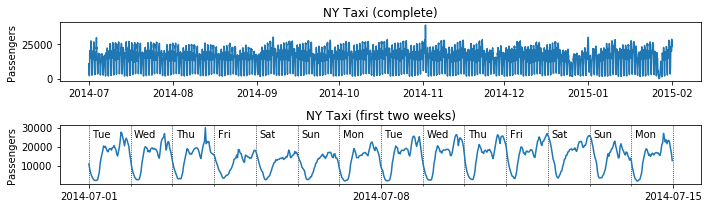

In [3]:
# Visualise the data
plt.figure(figsize=(10,3))
plt.subplot(2,1,1)
plt.title("NY Taxi (complete)")
plt.plot(data)
plt.ylabel("Passengers")

plt.subplot(2,1,2)
plt.title("NY Taxi (first two weeks)")
plt.plot(data.iloc[:2*24*7*2])
plt.ylabel("Passengers")

plt.gca().xaxis.set_major_locator(mdates.DayLocator([1, 8, 15]))
plt.gca().xaxis.set_minor_locator(mdates.DayLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))


plt.grid(b=True, axis="x", which='both', color='black', linestyle=':')

for i in range(14):
    timestamp = data.index[4+i * 48]
    plt.text(timestamp, 25000, timestamp.day_name()[:3])
plt.tight_layout()

# plt.savefig("ny_taxi.pdf", dpi=300, bbox_inches='tight')

In [4]:
# Define configuration for the Contextual Matrix Profile calculation.

m = 44  # 22 hours

# Each context starts between 0 and 2 AM, and lasts 22 hours
contexts = GeneralStaticManager([range(x*48, (x*48)+4) for x in range(len(data)//48)])

calc = AnytimeCalculator(m, data.values.T)

calc.add_generator(0, ZNormEuclidean()) # Znormalized Euclidean Distance

cmp = calc.add_consumer([0], ContextualMatrixProfile(contexts)) # We want to calculate CMP
mp = calc.add_consumer([0], MatrixProfileLR()) # We want to calculate MP

In [5]:
%%time

# Calculate Matrix Profile and Contextual Matrix Profile
calc.calculate_columns()

Wall time: 6.99 s


In [6]:
# Create boolean arrays to indicate whether each day is a weekday/weekend/saturday/sunday
weekdays = np.array([d in range(0,5) for d in data.index[::48].dayofweek])
weekends = np.array([d in range(5,7) for d in data.index[::48].dayofweek])
saturdays = np.array([d in range(5,6) for d in data.index[::48].dayofweek])
sundays = np.array([d in range(6,7) for d in data.index[::48].dayofweek])

day_labels = data.index[::48]

print("Dataset contains", len(day_labels), "days")

Dataset contains 215 days


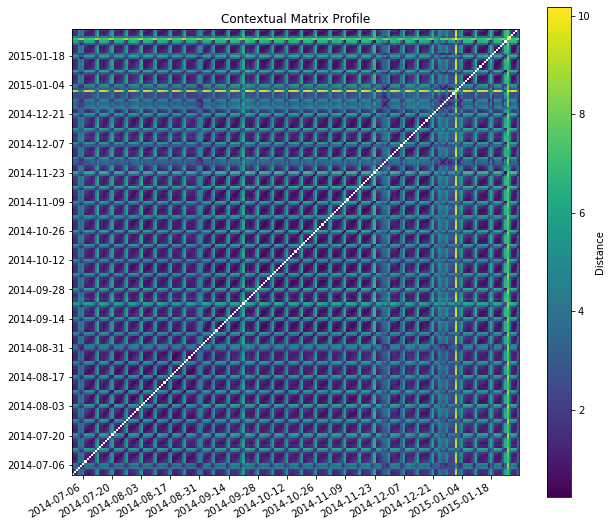

In [7]:
# Visualise the CMP
# Note the very subtle color difference before and after 2014-08-31

date_labels = mdates.date2num(data.index[::48].values)

plt.figure(figsize=(10,10))
extents = [date_labels[0], date_labels[-1], date_labels[0], date_labels[-1]]
plt.imshow(cmp.distance_matrix, extent=extents, cmap="viridis", origin="lower")
cbar = plt.colorbar()
plt.title("Contextual Matrix Profile")

# Label layout
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().yaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(14))
plt.gca().yaxis.set_major_locator(mticker.MultipleLocator(14))
plt.gcf().autofmt_xdate()
cbar.set_label("Distance")

# plt.savefig("ny_taxi_cmp.pdf", dpi=300, bbox_inches='tight')

Splitting on day 2014-09-01


([<matplotlib.axis.XTick at 0xb68d438>,
 <a list of 7 Text xticklabel objects>)

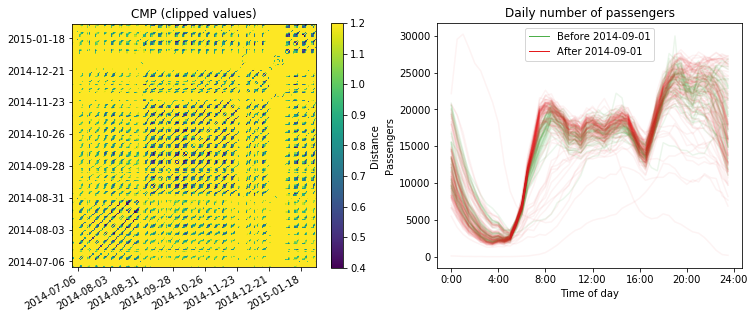

In [8]:
# Left: Visualise the same CMP, but highlight the subtle change before/after 2014-08-31
# Right: Plot the hourly behavior for all days before/after that date

# Left plot
date_labels = mdates.date2num(data.index[::48].values)

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)

extents = [date_labels[0], date_labels[-1], date_labels[0], date_labels[-1]]
plt.imshow(np.clip(cmp.distance_matrix, 0.4, 1.2), cmap="viridis", extent=extents, origin="lower")
cbar = plt.colorbar()
plt.title("CMP (clipped values)")

# Label layout
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().yaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(28))
plt.gca().yaxis.set_major_locator(mticker.MultipleLocator(28))
plt.gcf().autofmt_xdate()
cbar.set_label("Distance")


# Right plot
plt.subplot(1,2,2)
plt.title("Daily number of passengers")

DAY_TO_SPLIT = 62
split_date = str(data.index[::48][DAY_TO_SPLIT])[:10]
print("Splitting on day", split_date)


# List of colors suitable for the colorblind.
colors = ['#377eb8', '#ff7f00', '#4daf4a',
          '#f781bf', '#a65628', '#984ea3',
          '#999999', '#e41a1c', '#dede00']
c0 = colors[2]
c1 = colors[7]

# Plot before
for i in range(DAY_TO_SPLIT):
    if weekdays[i]:
        plt.plot(data.values[i*48:(i+1)*48], alpha=0.1, c=c0, label="x")

# Plot after
for x in range(DAY_TO_SPLIT,215):
    if weekdays[x]:
        plt.plot(data.values[x*48:(x+1)*48], alpha=0.05, c=c1, label="y")

custom_lines = [Line2D([0], [0], color=c0, lw=1),
                Line2D([0], [0], color=c1, lw=1)]
plt.legend(custom_lines, [f"Before {split_date}", f"After {split_date}"])

plt.xlabel("Time of day")
plt.ylabel("Passengers")
plt.xticks(
    range(0, 49, 8),
    ["{hour}:00".format(hour=(x // 2)) for x in range(0, 49, 8)]
)


# plt.savefig("ny_taxi_laborday.pdf", dpi=300, bbox_inches='tight')

In [9]:
# Create weekday/weekend only CMP
weekday_cmp = cmp.distance_matrix[:, weekdays][weekdays, :]
weekday_cmp[weekday_cmp == np.inf] = 0
weekday_dates = data.index[::48].values[weekdays]

weekend_cmp = cmp.distance_matrix[:, weekends][weekends, :]
weekend_cmp[weekend_cmp == np.inf] = 0
weekend_dates = data.index[::48].values[weekends]

saturday_cmp = cmp.distance_matrix[:, saturdays][saturdays, :]
saturday_cmp[saturday_cmp == np.inf] = 0
saturday_dates = data.index[::48].values[saturdays]

sunday_cmp = cmp.distance_matrix[:, sundays][sundays, :]
sunday_cmp[sunday_cmp == np.inf] = 0
sunday_dates = data.index[::48].values[sundays]

Text(0.5, 1.0, 'Contextual Matrix Profile (weekdays only)')

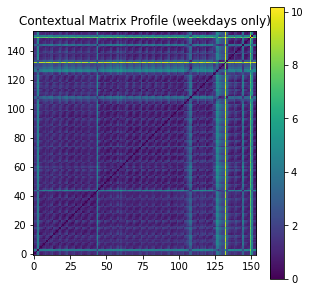

In [10]:
# Visualisation of weekday only CMP
date_labels = mdates.date2num(weekday_dates)

plt.figure(figsize=(5,5))
extents = [date_labels[0], date_labels[-1], date_labels[0], date_labels[-1]]
plt.imshow(weekday_cmp, cmap="viridis",
           origin="lower")
cbar = plt.colorbar()
plt.title("Contextual Matrix Profile (weekdays only)")

# Label layout - No longer correct due to the skips in the dates
# plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
# plt.gca().yaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
# plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(7))
# plt.gca().yaxis.set_major_locator(mticker.MultipleLocator(7))
# plt.gcf().autofmt_xdate()

Text(0.5, 1.0, 'Contextual Matrix Profile (weekends only)')

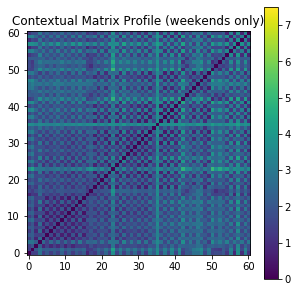

In [11]:
# Visualisation of weekend only CMP
# The checkerboard pattern indicates that it might be useful to split Saturday and Sunday.
date_labels = mdates.date2num(weekend_dates)

plt.figure(figsize=(5,5))
extents = [date_labels[0], date_labels[-1], date_labels[0], date_labels[-1]]
plt.imshow(weekend_cmp, cmap="viridis",
           origin="lower",
          vmin=0,
          vmax=7.5)
cbar = plt.colorbar()
plt.title("Contextual Matrix Profile (weekends only)")

Text(0.5, 1.0, 'CMP (Sundays only)')

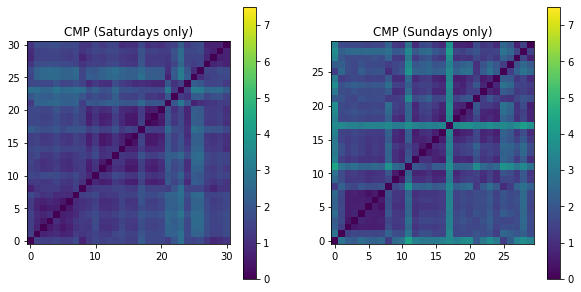

In [12]:
# Visualisation of CMP for Saturday and Sunday separately
plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)

date_labels = mdates.date2num(saturday_dates)
extents = [date_labels[0], date_labels[-1], date_labels[0], date_labels[-1]]
plt.imshow(saturday_cmp, cmap="viridis",
           origin="lower",
          vmin=0,
          vmax=7.5)
cbar = plt.colorbar()
plt.title("CMP (Saturdays only)")

plt.subplot(1, 2, 2)

date_labels = mdates.date2num(sunday_dates)
extents = [date_labels[0], date_labels[-1], date_labels[0], date_labels[-1]]
plt.imshow(sunday_cmp, cmap="viridis",
           origin="lower",
          vmin=0,
          vmax=7.5)
cbar = plt.colorbar()
plt.title("CMP (Sundays only)")

In [13]:
# Calculate an anomaly score by summing the values (per type of day) across one axis
cmp_weekday_score = np.nansum(weekday_cmp, axis=1) / np.count_nonzero(weekdays)
cmp_saturday_score = np.nansum(saturday_cmp, axis=1) / np.count_nonzero(saturdays)
cmp_sunday_score = np.nansum(sunday_cmp, axis=1) / np.count_nonzero(sundays)

# Merge the scores for all types of day into one array
cmp_ad_score = np.zeros(len(cmp.distance_matrix))
cmp_ad_score[saturdays] = cmp_saturday_score
cmp_ad_score[sundays] = cmp_sunday_score
cmp_ad_score[weekdays] = cmp_weekday_score

# Ordering of all days, from most to least anomalous
ad_order = np.argsort(cmp_ad_score)[::-1]

([<matplotlib.axis.XTick at 0xcd1d9e8>,
 <a list of 6 Text xticklabel objects>)

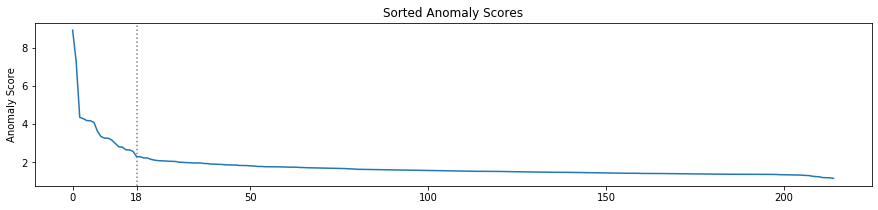

In [14]:
# Plot the anomaly scores and our considered threshold
plt.figure(figsize=(15,3))
plt.title("Sorted Anomaly Scores")
plt.plot(cmp_ad_score[ad_order])
plt.ylabel("Anomaly Score")

plt.axvline(18, ls=":", c="gray")
plt.xticks([0, 18, 50, 100, 150, 200])

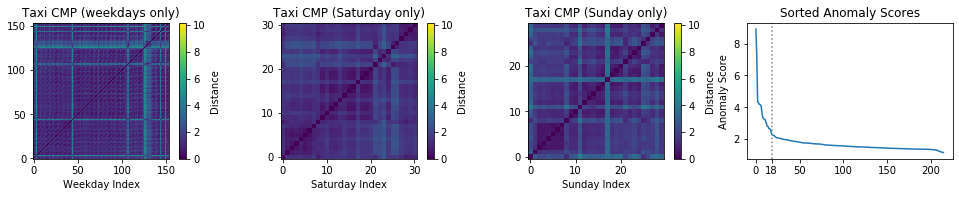

In [15]:
# Plot the above figures together

max_cmp_val = np.max([
    np.max(weekday_cmp),
    np.max(saturday_cmp),
    np.max(sunday_cmp)
])
min_cmp_val = np.min([
    np.min(weekday_cmp),
    np.min(saturday_cmp),
    np.min(sunday_cmp)
])

plt.figure(figsize=(17,2.5))
plt.subplot(1,4,1)
date_labels = mdates.date2num(weekday_dates)
extents = [date_labels[0], date_labels[-1], date_labels[0], date_labels[-1]]
plt.imshow(weekday_cmp, cmap="viridis",
           origin="lower",
           vmin=min_cmp_val,
           vmax=max_cmp_val,
          )
cbar = plt.colorbar()
plt.xlabel("Weekday Index")
plt.yticks([0,50,100,150])
plt.title("Taxi CMP (weekdays only)")
cbar.set_label("Distance")



plt.subplot(1,4,2)
date_labels = mdates.date2num(saturday_dates)
extents = [date_labels[0], date_labels[-1], date_labels[0], date_labels[-1]]
plt.imshow(saturday_cmp, cmap="viridis",
           origin="lower",
          vmin=min_cmp_val,
           vmax=max_cmp_val,
          )
cbar = plt.colorbar()
plt.xlabel("Saturday Index")
plt.yticks([0,10, 20, 30])
plt.title("Taxi CMP (Saturday only)")
cbar.set_label("Distance")


plt.subplot(1,4,3)
date_labels = mdates.date2num(sunday_dates)
extents = [date_labels[0], date_labels[-1], date_labels[0], date_labels[-1]]
plt.imshow(sunday_cmp, cmap="viridis",
           origin="lower",
          vmin=min_cmp_val,
           vmax=max_cmp_val,
          )
cbar = plt.colorbar()
plt.xlabel("Sunday Index")
plt.yticks([0,10, 20])
plt.title("Taxi CMP (Sunday only)")
cbar.set_label("Distance")


plt.subplot(1,4,4)
plt.title("Sorted Anomaly Scores")
plt.plot(cmp_ad_score[ad_order])
plt.ylabel("Anomaly Score")


plt.axvline(18, ls=":", c="gray")
plt.xticks([0, 18, 50, 100, 150, 200])

plt.show()

#plt.savefig("ny_taxi_cmp_detail.pdf", dpi=300, bbox_inches='tight')

In [16]:
# Display the top anomalies according to the CMP.
# In the paper we take the top 18 anomalies, but output more here out of interest
print("Top anomalies according to CMP")

for i in range(30):
    anomaly_index = ad_order[i]
    date = day_labels[anomaly_index]
    print(i, date.day_name(), str(date)[:10], "\t", np.round(cmp_ad_score[anomaly_index], 2))

Top anomalies according to CMP
0 Thursday 2015-01-01 	 8.92
1 Monday 2015-01-26 	 7.26
2 Wednesday 2014-12-24 	 4.35
3 Tuesday 2015-01-27 	 4.27
4 Friday 2014-07-04 	 4.17
5 Monday 2014-09-01 	 4.17
6 Thursday 2014-12-25 	 4.08
7 Monday 2015-01-19 	 3.61
8 Sunday 2014-11-02 	 3.33
9 Friday 2014-12-26 	 3.25
10 Friday 2014-11-28 	 3.25
11 Thursday 2014-11-27 	 3.15
12 Friday 2015-01-02 	 2.98
13 Monday 2014-12-29 	 2.8
14 Sunday 2014-07-06 	 2.78
15 Wednesday 2014-12-31 	 2.64
16 Sunday 2014-09-21 	 2.64
17 Tuesday 2014-12-30 	 2.56
18 Wednesday 2014-11-26 	 2.28
19 Tuesday 2014-12-23 	 2.28
20 Saturday 2014-12-13 	 2.21
21 Sunday 2015-01-18 	 2.21
22 Sunday 2014-12-28 	 2.14
23 Friday 2014-12-12 	 2.1
24 Sunday 2014-08-31 	 2.07
25 Saturday 2015-01-03 	 2.07
26 Saturday 2014-12-27 	 2.06
27 Monday 2015-01-05 	 2.04
28 Monday 2014-10-13 	 2.04
29 Friday 2014-08-29 	 2.03


Text(0, 0.5, 'Distance')

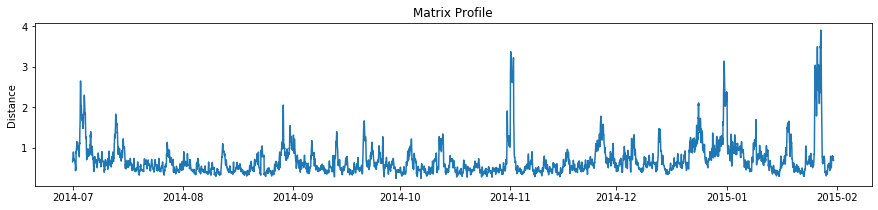

In [17]:
# Plot of the Matrix Profile
plt.figure(figsize=(15,3))
plt.title("Matrix Profile")
plt.plot(data.index[:len(mp.matrix_profile())], mp.matrix_profile())
plt.ylabel("Distance")

# plt.savefig("ny_taxi_mp.pdf", dpi=300, bbox_inches='tight')

([<matplotlib.axis.XTick at 0xb9e7320>,
 <a list of 6 Text xticklabel objects>)

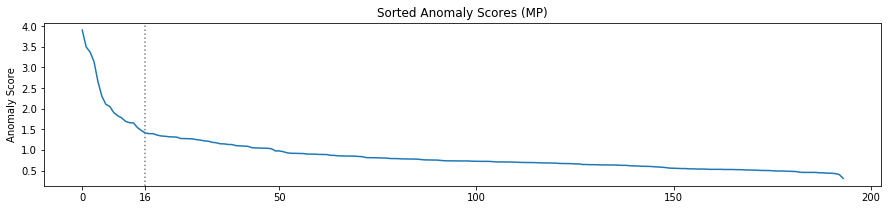

In [18]:
# Sort the anomaly scores for Matrix Profile in a similar way.
# First, gather the indices of the top values of the MP, where each index is
# at least 44 (22 hours) apart from any previous index
mp_ad_order = list(highest_value_idxs(mp.matrix_profile(), 44))

plt.figure(figsize=(15,3))
plt.plot(mp.matrix_profile()[mp_ad_order])

plt.title("Sorted Anomaly Scores (MP)")
plt.ylabel("Anomaly Score")

#plt.axvline(5, ls=":", c="gray")
#plt.axvline(11, ls=":", c="gray")
plt.axvline(16, ls=":", c="gray")
plt.xticks([0, 16, 50, 100, 150, 200])


In [19]:
# Display the top anomalies according to the MP.
# Again, we output more than the 16 anomalies we consider in the paper.
print("Top anomalies according to MP")

for i, idx in enumerate(itertools.islice(highest_value_idxs(mp.matrix_profile(), 44), 25)):
    date = data.index[idx]
    print(i, date.day_name(), date, "\t", np.round(mp.matrix_profile()[idx], 2))

Top anomalies according to MP
0 Tuesday 2015-01-27 12:00:00 	 3.9
1 Monday 2015-01-26 13:00:00 	 3.5
2 Saturday 2014-11-01 06:30:00 	 3.37
3 Wednesday 2014-12-31 07:30:00 	 3.14
4 Thursday 2014-07-03 05:30:00 	 2.65
5 Friday 2014-07-04 07:00:00 	 2.3
6 Wednesday 2014-12-24 03:00:00 	 2.11
7 Friday 2014-08-29 06:30:00 	 2.05
8 Friday 2014-10-31 07:00:00 	 1.91
9 Sunday 2014-07-13 03:30:00 	 1.83
10 Wednesday 2014-11-26 15:00:00 	 1.78
11 Friday 2015-01-09 06:30:00 	 1.69
12 Sunday 2014-09-21 01:00:00 	 1.66
13 Sunday 2015-01-18 12:30:00 	 1.65
14 Sunday 2014-08-31 04:30:00 	 1.54
15 Saturday 2014-12-13 00:00:00 	 1.47
16 Thursday 2014-12-25 03:30:00 	 1.41
17 Saturday 2014-09-13 07:00:00 	 1.4
18 Sunday 2014-07-06 02:00:00 	 1.4
19 Sunday 2014-12-28 02:00:00 	 1.36
20 Monday 2014-10-13 03:30:00 	 1.34
21 Friday 2015-01-02 07:00:00 	 1.33
22 Friday 2014-12-05 22:30:00 	 1.32
23 Saturday 2015-01-03 06:30:00 	 1.32
24 Monday 2014-09-01 03:00:00 	 1.31


Text(0.5, 0, 'Time of day')

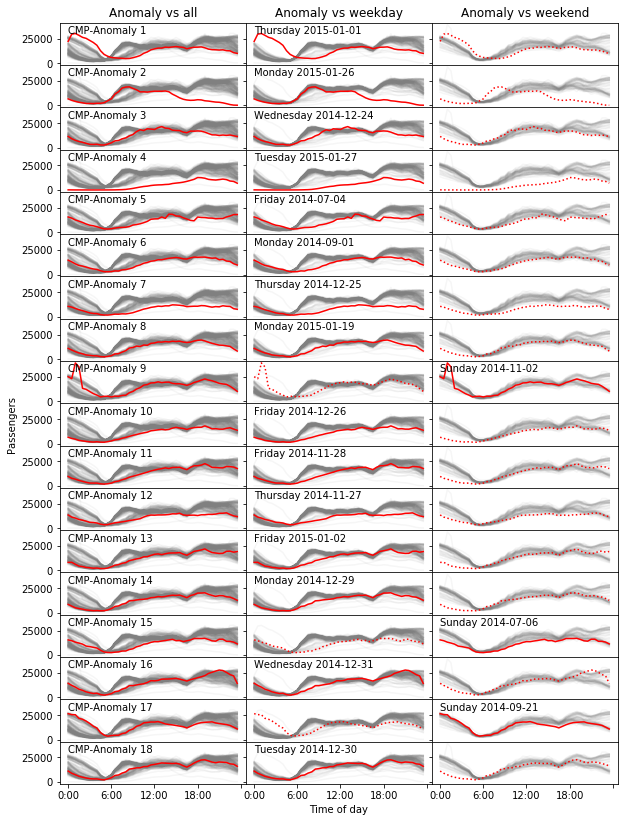

In [20]:
# Visualise the top anomalies according to the CMP
num_anomalies_to_show = 18

fig, ax = plt.subplots(num_anomalies_to_show, 3, sharex=True, sharey=True, figsize=(10,14), gridspec_kw = {'wspace':0., 'hspace':0.})

ax[0,0].set_title("Anomaly vs all")
ax[0,1].set_title("Anomaly vs weekday")
ax[0,2].set_title("Anomaly vs weekend")

for i in range(num_anomalies_to_show):
    
    anomaly_index = ad_order[i]
    anomaly_range = range(48 * anomaly_index, 48 * (anomaly_index + 1))
    date = day_labels[anomaly_index]
    
    if date.dayofweek in (5, 6):
        ls1 = ":"
        ls2 = "-"
        date_col = 2
    else:
        ls1 = "-"
        ls2 = ":"
        date_col = 1
    
    ax[i, 0].plot(data.values.reshape((-1, 48)).T, c="gray", alpha=0.07)
    ax[i, 0].plot(data.values[anomaly_range], c="red")
    
    ax[i, 1].plot(data.values.reshape((-1, 48))[weekdays].T, c="gray", alpha=0.07)
    ax[i, 1].plot(data.values[anomaly_range], c="red", linestyle=ls1)
    
    
    ax[i, 2].plot(data.values.reshape((-1, 48))[weekends].T, c="gray", alpha=0.07)
    ax[i, 2].plot(data.values[anomaly_range], c="red", linestyle=ls2)
    
    
    ax[i, 0].text(0, 30000, "CMP-Anomaly " + str(i + 1))
    ax[i, date_col].text(0, 30000, date.day_name() + " " + str(date)[:10])


ax[0, 0].set_xticks(range(0, 49, 12))
ticklabels = ["{hour}:00".format(hour=(x // 2)) for x in range(0, 49, 12)]
ticklabels[-1] = ""
ax[0, 0].set_xticklabels(ticklabels)
    
#plt.tight_layout()

ax[num_anomalies_to_show//2, 0].set_ylabel("Passengers")
ax[num_anomalies_to_show-1, 1].set_xlabel("Time of day")

# plt.savefig("ny_taxi_cmp_anomalies.pdf", dpi=300, bbox_inches='tight')

Text(0.5, 0, 'Time of day')

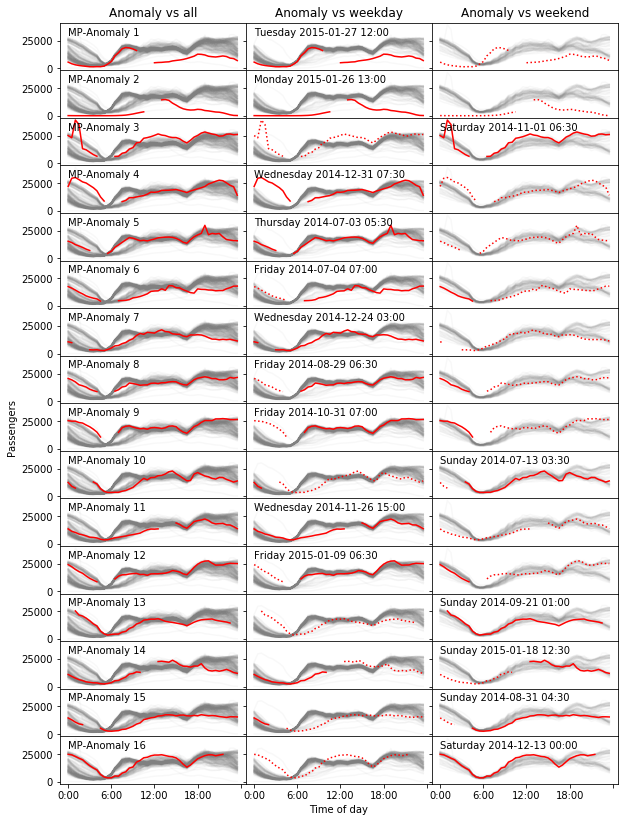

In [21]:
# Visualise the top anomalies according to the MP
num_anomalies_to_show = 16

fig, ax = plt.subplots(num_anomalies_to_show, 3, sharex=True, sharey=True, figsize=(10,14), gridspec_kw = {'wspace':0., 'hspace':0.})
ax[0,0].set_title("Anomaly vs all")
ax[0,1].set_title("Anomaly vs weekday")
ax[0,2].set_title("Anomaly vs weekend")

mp_cached = mp.matrix_profile()
for i, anomaly_index in enumerate(itertools.islice(highest_value_idxs(mp_cached, 44), num_anomalies_to_show)):
    
    # Anomalies can be split over 2 days here
    day_index = anomaly_index // 48
    day_shift = anomaly_index % 48
    anomaly_range_x1 = range(0, day_shift)
    anomaly_range_y1 = range(day_index * 48, day_index * 48 + day_shift)
    anomaly_range_x2 = range(day_shift, min(day_shift + m, 48))
    anomaly_range_y2 = range(day_index * 48 + day_shift, day_index * 48 + day_shift + len(anomaly_range_x2))
    anomaly_range_x3 = range(0, day_shift - (48-m))
    anomaly_range_y3 = range(day_index * 48 + day_shift + len(anomaly_range_x2), (day_index + 1) * 48 + anomaly_range_x3.stop - anomaly_range_x3.start)
    anomaly_range_x4 = range(day_shift - (48-m), 48)
    anomaly_range_y4 = range((day_index + 1) * 48 + len(anomaly_range_x3), (day_index + 2) * 48)
    
    date1 = data.index[anomaly_index]
    date2 = data.index[anomaly_index + 48]
    
    if date1.dayofweek in (5, 6):
        ls1, ls3 = (":", "-")
        date_col = 2
    else:
        ls1, ls3 = ("-", ":")
        date_col = 1
    if date2.dayofweek in (5, 6):
        ls2, ls4 = (":", "-")
    else:
        ls2, ls4 = ("-", ":")
        
    
    ax[i, 0].plot(data.values.reshape((-1, 48)).T, c="gray", alpha=0.05)
    ax[i, 0].plot(anomaly_range_x2, data.values[anomaly_range_y2], c="red")
    ax[i, 0].plot(anomaly_range_x3, data.values[anomaly_range_y3], c="red")
    
    ax[i, 1].plot(data.values.reshape((-1, 48))[weekdays].T, c="gray", alpha=0.05)
    ax[i, 1].plot(anomaly_range_x2, data.values[anomaly_range_y2], c="red", linestyle=ls1)
    ax[i, 1].plot(anomaly_range_x3, data.values[anomaly_range_y3], c="red", linestyle=ls2)
    
    ax[i, 2].plot(data.values.reshape((-1, 48))[weekends].T, c="gray", alpha=0.05)
    ax[i, 2].plot(anomaly_range_x2, data.values[anomaly_range_y2], c="red", linestyle=ls3)
    ax[i, 2].plot(anomaly_range_x3, data.values[anomaly_range_y3], c="red", linestyle=ls4)
    
    
    ax[i, 0].text(0, 30000, "MP-Anomaly " + str(i + 1))
    ax[i, date_col].text(0, 30000, date1.day_name() + " " + str(date1)[:16])

ax[0, 0].set_xticks(range(0, 49, 12))
ticklabels = ["{hour}:00".format(hour=(x // 2)) for x in range(0, 49, 12)]
ticklabels[-1] = ""
ax[0, 0].set_xticklabels(ticklabels)

#plt.tight_layout()

ax[num_anomalies_to_show//2, 0].set_ylabel("Passengers")
ax[num_anomalies_to_show-1, 1].set_xlabel("Time of day")

# plt.savefig("ny_taxi_mp_anomalies.pdf", dpi=300, bbox_inches='tight')

In [22]:
# Labor day (Sept 1) is not detected by MP as anomalous,
# because it closely resembles weekend days or Martin Luther King Day (2015-01-19).

x = 2*24*62

for offset in range(16):
    match_date = data.index[mp.profile_index()[x+offset]]
    print("Best MP match for", data.index[x+offset], "is", match_date.day_name(), match_date,
         " - MPDist: ", np.round(mp_cached[x+offset], 2))

Best MP match for 2014-09-01 00:00:00 is Saturday 2014-12-27 00:00:00  - MPDist:  0.93
Best MP match for 2014-09-01 00:30:00 is Sunday 2015-01-18 23:00:00  - MPDist:  1.02
Best MP match for 2014-09-01 01:00:00 is Sunday 2015-01-18 23:30:00  - MPDist:  1.01
Best MP match for 2014-09-01 01:30:00 is Monday 2015-01-19 00:00:00  - MPDist:  1.1
Best MP match for 2014-09-01 02:00:00 is Monday 2015-01-19 00:30:00  - MPDist:  1.23
Best MP match for 2014-09-01 02:30:00 is Monday 2015-01-19 01:30:00  - MPDist:  1.29
Best MP match for 2014-09-01 03:00:00 is Sunday 2014-07-06 03:30:00  - MPDist:  1.31
Best MP match for 2014-09-01 03:30:00 is Sunday 2014-07-06 04:00:00  - MPDist:  1.27
Best MP match for 2014-09-01 04:00:00 is Sunday 2014-07-06 04:30:00  - MPDist:  1.21
Best MP match for 2014-09-01 04:30:00 is Sunday 2014-08-03 04:30:00  - MPDist:  0.97
Best MP match for 2014-09-01 05:00:00 is Sunday 2014-08-03 05:00:00  - MPDist:  0.9
Best MP match for 2014-09-01 05:30:00 is Sunday 2014-08-03 05:30: